In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore
import seaborn as sns

In [2]:
from datetime import datetime

# CUSTOMER SEGMENTATION 

In [3]:
#loading the dataset 
data = pd.read_csv('customer_data.csv',error_bad_lines=False,engine = 'python',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})

In [4]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
406824,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
406825,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
406826,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
406827,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406829 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      406829 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 24.8+ MB


Correcting the invoice number and converting to numeric type

In [6]:
#data['InvoiceNo'] = pd.to_numeric(data['InvoiceNo']) gives error , as there are faulty values in the column

#removing the C prefix in the InvoiceNo code value
data['InvoiceNo'] = data['InvoiceNo'].apply(lambda x: x.replace('C',""))

#Converting InvoiceNo to numeric type
data['InvoiceNo'] = pd.to_numeric(data['InvoiceNo'])

Correcting the StockCode and converting to numeric type

In [7]:
# #removing the character suffix from the values
data['StockCode'] = data['StockCode'].replace(r'[A-Za-z]$', '', regex=True)

# Converting it to numeric type
data['StockCode'] = pd.to_numeric(data['StockCode'],errors='coerce')

#dealing with the na values
data['StockCode'] = data['StockCode'].fillna(-1)

In [8]:
#converting Stockcode from float to int
data['StockCode'] = data['StockCode'].astype(int)

In [9]:
#converting invoice date to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [10]:
tab_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,int64,int32,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#dropping na values - we drop them here as there is no way to get the customer data back , hence it becomes irrelevant.
data = data.dropna(subset=['Quantity', 'UnitPrice'])

Handling the duplicates

In [12]:
print('Duplicate Entries:- {}'.format(data.duplicated().sum()))

Duplicate Entries:- 5260


In [13]:
#removing the duplicates.
data.drop_duplicates(inplace = True)

In [14]:
data['CustomerID'] = data['CustomerID'].drop_duplicates()

In [15]:
data = data.dropna(subset=['CustomerID'])

In [16]:
customer_count = len(data['CustomerID'].value_counts())
print('Customer count= ',customer_count)

Customer count=  4372


In [17]:
data.set_index('CustomerID',inplace=True)

Outlier Analysis

In [18]:
data.describe()

,InvoiceNo,StockCode,Quantity,UnitPrice
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,552338.364593,31966.566789,44.950137,6.756217
std,13079.529764,22463.378010,1153.316383,79.265214
min,536365.000000,-1.000000,1.000000,0.000000
25%,540946.750000,21928.000000,2.000000,1.250000
50%,548541.500000,22609.500000,6.000000,2.100000
75%,563440.500000,23240.000000,12.000000,4.950000
max,581578.000000,90210.000000,74215.000000,4287.630000


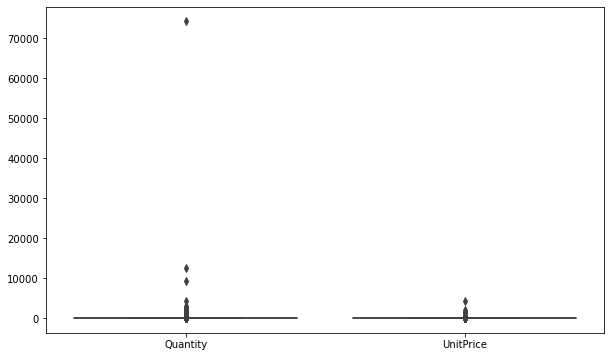

In [19]:
#creating box plot for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Quantity', 'UnitPrice']])
plt.show()

In [20]:
# Calculate IQR for Quantity and UnitPrice
Q1 = data[['Quantity', 'UnitPrice']].quantile(0.25)
Q3 = data[['Quantity', 'UnitPrice']].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
outliers = ((data[['Quantity', 'UnitPrice']] < lower_bound) | (data[['Quantity', 'UnitPrice']] > upper_bound)).any(axis=1)
df_no_outliers = data[~outliers]

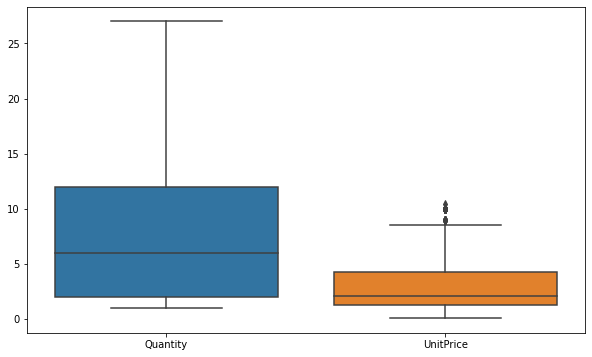

In [21]:
# Create box plots after handling outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_no_outliers[['Quantity', 'UnitPrice']])
plt.show()

In [22]:
#feature engineering

data['Total_Purchase'] = data['UnitPrice']*data['Quantity']

# Creating features - day, month, and year
data['Day'] = data['InvoiceDate'].dt.day
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year

Product Insights

In [23]:
pd.DataFrame([{'products': len(data['StockCode'].value_counts()),    
               'transactions': len(data['InvoiceNo'].value_counts()),
               'customers': customer_count,  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,1559,4372,4372


4372 users - 1559 products

In [24]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})#number of products per basket can be used for further analysis.

In [25]:
#RFM analysis
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
latest_purchase_date = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()

#recency
current_date = datetime.now()
latest_purchase_date['Recency'] = (current_date - latest_purchase_date['InvoiceDate']).dt.days

#frequency
frequency = data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency.columns = ['CustomerID', 'Frequency']

#monetary
data['TotalAmount'] = data['Quantity'] * data['UnitPrice']

monetary = data.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetary.columns = ['CustomerID', 'Monetary']

In [26]:
# Merging Recency, Frequency, and Monetary dataframes
rfm_df = pd.merge(latest_purchase_date[['CustomerID', 'Recency']], frequency, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary, on='CustomerID')

In [27]:
from sklearn.cluster import KMeans

# Selecting features for clustering (Recency, Frequency, Monetary)
X = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Choosing n value(parameter value)
n_clusters = 4

# Training the K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(X)

In [28]:
#Interpretation and Validation
# Descriptive statistics for each cluster
cluster_stats = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()

print(cluster_stats)

   Cluster      Recency  Frequency      Monetary  CustomerID
0        0  4651.321521        1.0     36.520561        2709
1        1  4669.000000        1.0  77183.600000           1
2        2  4434.863884        1.0     30.148167        1653
3        3  4563.222222        1.0   3049.640000           9


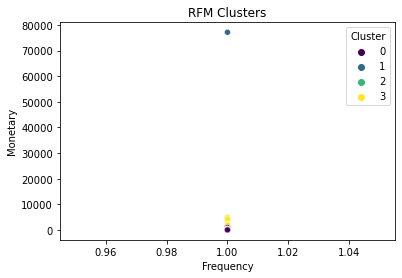

In [29]:
# Visualizing the clusters
sns.scatterplot(data=rfm_df, x='Frequency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('RFM Clusters')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [30]:
#Customer Persona Creation
# Creating Persona List values
persona_names = {
    0: 'High Recency, Low Frequency, Low Monetary',
    1: 'Low Recency, High Frequency, High Monetary',
    2: 'High Recency, Low Frequency, High Monetary',
    3: 'Low Recency, High Frequency, Low Monetary'
}

# Creating Persona column for the dataframe
rfm_df['Persona'] = rfm_df['Cluster'].map(persona_names)

The personas provide a meaningful way to interpret and communicate the characteristics of each cluster.We can now adjust the code and visualizations based on specific needs and preferences. 

In [31]:
list_product = data['Description'].unique()
X = pd.DataFrame()

for idx, key in enumerate(list_product):
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), list_product))


In [32]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_product):
    prix = data[ data['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [33]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       393                 
1<.<2       440                 
2<.<3       267                 
3<.<5       235                 
5<.<10      213                 
.>10        86                  


In [34]:
from sklearn.metrics import silhouette_score

matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.189565930858808
For n_clusters = 4 The average silhouette_score is : 0.2335864133817063
For n_clusters = 5 The average silhouette_score is : 0.2710919624342178
For n_clusters = 6 The average silhouette_score is : 0.28986720496705604
For n_clusters = 7 The average silhouette_score is : 0.2483586635971056
For n_clusters = 8 The average silhouette_score is : 0.22209734733921468
For n_clusters = 9 The average silhouette_score is : 0.16740601905947014


In [35]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.2710919624342178


In [36]:
pd.Series(clusters).value_counts()

1    440
3    393
0    299
4    267
2    235
dtype: int64

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

In [40]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

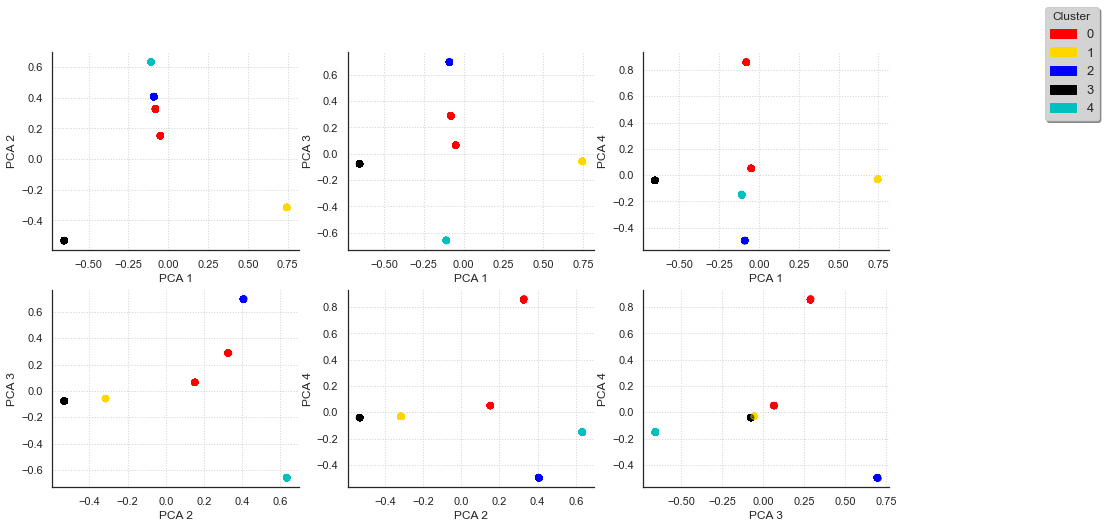

In [41]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In [42]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [43]:
X = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

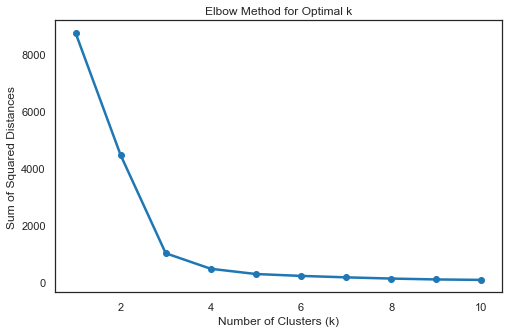

In [44]:
#Calculating the sum of squared distances for different values of k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

#Ploting the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [45]:
# Choose the optimal k (number of clusters)
optimal_k = 3  # replace with the value you determined from the Elbow Method

# Train the K-means model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Recency', 'Frequency', 'Monetary'])
print(cluster_centers)

       Recency  Frequency      Monetary
0  4650.991553        1.0     40.873570
1  4434.271238        1.0     39.391475
2  4669.000000        1.0  77183.600000


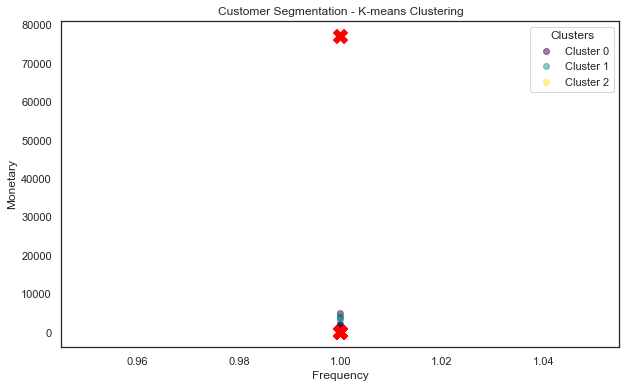

In [46]:
#visualizing the clusters

plt.figure(figsize=(10, 6))
scatter = plt.scatter(rfm_df['Frequency'], rfm_df['Monetary'], c=rfm_df['Cluster'], cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers['Frequency'], cluster_centers['Monetary'], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('Customer Segmentation - K-means Clustering')
plt.xlabel('Frequency')
plt.ylabel('Monetary')

legend_labels = [f'Cluster {i}' for i in range(optimal_k)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters', loc='upper right')

plt.show()